# Convolutional Neural Network for Finding Ground Control Points
In this notebook, we mess around with the VGG16 model. Because this model takes 224 x 224 images, we have already collected 2 directories full of sample data with and without ground control points. Ultimately, we want a network that tell us whether or not the image has a target in it. This classifier network can be used to search an image for targets, and serves as a launching point for identifying and classifying other stuff.

Import Tensorflow/Keras utilities needed for the CNN. Also import OS, Numpy, MatPlotLib, and OpenCV.

In [1]:
import tensorflow as tf
from tensorflow.python.keras.layers import Input, Dense, Flatten, Dropout, BatchNormalization
from tensorflow.python.keras import initializers, optimizers
from tensorflow.python.keras.models import Model
from tensorflow.python.keras.utils import Sequence
from tensorflow.python.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.python.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.python.keras.preprocessing import image
import os
import numpy as np
from numpy import array
import h5py
import cv2
vggmean = array([103.939,116.779,123.68], dtype=np.float32)
import matplotlib.pyplot as plt

Set a seed for a random number generator, and load the VGG16 model. VGG16 model is a CNN designed to recognize 1000 different types of image. I'm using this model by taking away its last 3 layers and bolting on my own layers. This will create a CNN where instead of 1000 output nodes, there is only 1 that fires off when there is a GCP in a picture.

In [2]:
np.random.seed(0)

# The VGG16 Model
We start with a pre-built, pre-trained deep-learning ImageNet VGG16 model. It's readily available as part of the Keras library. After we load it in with the statement below, we will take a chainsaw to the back-end of it and gently sew on the network that we train.

In [3]:
vgg16_model = VGG16(weights='imagenet', include_top=True)

In [4]:
vgg16_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

Create a "left model" of the VGG16 network where the last 3 layers are left off.

In [5]:
leftModel = Model(inputs=vgg16_model.input, outputs=vgg16_model.get_layer('flatten').output)

In [6]:
leftModel.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

# The Data
Grab the filenames for pictures that contain targets and picutres that don't contain targets. Then count them all up and create a combined list of all filenames.

In [6]:
targetFilenames = ['data/Targets/'+f for f in os.listdir('data/Targets')]
nontargetFilenames = ['data/NonTargets/'+f for f in os.listdir('data/NonTargets')]

In [7]:
imageCount = len(targetFilenames)+len(nontargetFilenames)
filenames = targetFilenames+nontargetFilenames

These are examples of how an image with a target and an image with no target look. These images were manually curated from drone flights.

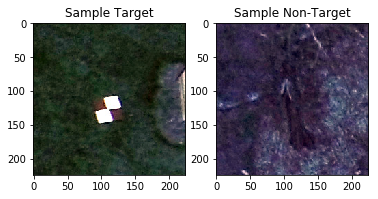

In [31]:
sampleTargetImage = cv2.imread(targetFilenames[1])
sampleNontargetImage = cv2.imread(nontargetFilenames[0])
plt.figure()
plt.subplot(121)
plt.imshow(sampleTargetImage)
plt.title("Sample Target")

plt.subplot(122)
plt.imshow(sampleNontargetImage)
plt.title("Sample Non-Target");

Create an array of ones and zeros. Ones being repesentative of the pictures with targets and zeros being the pictures without targets.

In [8]:
labels = np.hstack((np.ones((len(targetFilenames))), np.zeros((len(nontargetFilenames)))))

In [9]:
labels.shape

(3943,)

# Converting Images into Features
Process images with OpenCV and generate predictions.

In [11]:
features = np.zeros((imageCount, 25088))
for i, filename in enumerate(filenames):
    print('processing: {} {}'.format(i, filename))
    color = cv2.imread(filename)
    processed = color - vggmean
    x = leftModel.predict(processed.reshape((1, 224, 224, 3)))
    features[i] = x.reshape((-1,))

processing: 0 data/Targets/nontarget1533.png
processing: 1 data/Targets/target1370.png
processing: 2 data/Targets/target1296.png
processing: 3 data/Targets/target0748.png
processing: 4 data/Targets/target0365.png
processing: 5 data/Targets/target1310.png
processing: 6 data/Targets/target0371.png
processing: 7 data/Targets/target0797.png
processing: 8 data/Targets/target0841.png
processing: 9 data/Targets/target0716.png
processing: 10 data/Targets/target1256.png
processing: 11 data/Targets/target0934.png
processing: 12 data/Targets/target0913.png
processing: 13 data/Targets/target1612.png
processing: 14 data/Targets/target1866.png
processing: 15 data/Targets/target1865.png
processing: 16 data/Targets/target0393.png
processing: 17 data/Targets/target0630.png
processing: 18 data/Targets/target1935.png
processing: 19 data/Targets/target0370.png
processing: 20 data/Targets/target0496.png
processing: 21 data/Targets/target0500.png
processing: 22 data/Targets/target1315.png
processing: 23 dat

processing: 189 data/Targets/target1397.png
processing: 190 data/Targets/target1918.png
processing: 191 data/Targets/target1461.png
processing: 192 data/Targets/target0196.png
processing: 193 data/Targets/target1444.png
processing: 194 data/Targets/target0325.png
processing: 195 data/Targets/target0555.png
processing: 196 data/Targets/target1248.png
processing: 197 data/Targets/target1208.png
processing: 198 data/Targets/target1858.png
processing: 199 data/Targets/target0677.png
processing: 200 data/Targets/target1158.png
processing: 201 data/Targets/target0967.png
processing: 202 data/Targets/target0137.png
processing: 203 data/Targets/target1912.png
processing: 204 data/Targets/target1628.png
processing: 205 data/Targets/target0965.png
processing: 206 data/Targets/target1682.png
processing: 207 data/Targets/target1407.png
processing: 208 data/Targets/target0474.png
processing: 209 data/Targets/target1655.png
processing: 210 data/Targets/target1451.png
processing: 211 data/Targets/tar

processing: 385 data/Targets/target0006.png
processing: 386 data/Targets/target0745.png
processing: 387 data/Targets/target1422.png
processing: 388 data/Targets/target0847.png
processing: 389 data/Targets/target1602.png
processing: 390 data/Targets/target0256.png
processing: 391 data/Targets/target0260.png
processing: 392 data/Targets/target1394.png
processing: 393 data/Targets/target0226.png
processing: 394 data/Targets/target0113.png
processing: 395 data/Targets/target1182.png
processing: 396 data/Targets/target1392.png
processing: 397 data/Targets/target0966.png
processing: 398 data/Targets/target0026.png
processing: 399 data/Targets/target1096.png
processing: 400 data/Targets/target1257.png
processing: 401 data/Targets/target1284.png
processing: 402 data/Targets/target1573.png
processing: 403 data/Targets/target0321.png
processing: 404 data/Targets/target1537.png
processing: 405 data/Targets/target1283.png
processing: 406 data/Targets/target0806.png
processing: 407 data/Targets/tar

processing: 576 data/Targets/target0155.png
processing: 577 data/Targets/target1474.png
processing: 578 data/Targets/target0253.png
processing: 579 data/Targets/target1502.png
processing: 580 data/Targets/target0456.png
processing: 581 data/Targets/target0750.png
processing: 582 data/Targets/target0429.png
processing: 583 data/Targets/target0449.png
processing: 584 data/Targets/target0718.png
processing: 585 data/Targets/target0338.png
processing: 586 data/Targets/target1449.png
processing: 587 data/Targets/target1185.png
processing: 588 data/Targets/target0603.png
processing: 589 data/Targets/target0926.png
processing: 590 data/Targets/target1194.png
processing: 591 data/Targets/target0600.png
processing: 592 data/Targets/target1336.png
processing: 593 data/Targets/target0622.png
processing: 594 data/Targets/target0102.png
processing: 595 data/Targets/target1462.png
processing: 596 data/Targets/target0072.png
processing: 597 data/Targets/target0460.png
processing: 598 data/Targets/tar

processing: 772 data/Targets/target1197.png
processing: 773 data/Targets/target1235.png
processing: 774 data/Targets/target1312.png
processing: 775 data/Targets/target1581.png
processing: 776 data/Targets/target1535.png
processing: 777 data/Targets/target0919.png
processing: 778 data/Targets/target0885.png
processing: 779 data/Targets/target1648.png
processing: 780 data/Targets/target0888.png
processing: 781 data/Targets/target1916.png
processing: 782 data/Targets/target0551.png
processing: 783 data/Targets/target0280.png
processing: 784 data/Targets/target1524.png
processing: 785 data/Targets/target1635.png
processing: 786 data/Targets/target1606.png
processing: 787 data/Targets/target0458.png
processing: 788 data/Targets/target0942.png
processing: 789 data/Targets/target1754.png
processing: 790 data/Targets/target0835.png
processing: 791 data/Targets/target0176.png
processing: 792 data/Targets/target0124.png
processing: 793 data/Targets/target1852.png
processing: 794 data/Targets/tar

processing: 965 data/Targets/target1556.png
processing: 966 data/Targets/target1716.png
processing: 967 data/Targets/target0956.png
processing: 968 data/Targets/target1898.png
processing: 969 data/Targets/target0578.png
processing: 970 data/Targets/target1387.png
processing: 971 data/Targets/target1068.png
processing: 972 data/Targets/target1167.png
processing: 973 data/Targets/target0392.png
processing: 974 data/Targets/target1459.png
processing: 975 data/Targets/target1127.png
processing: 976 data/Targets/target0005.png
processing: 977 data/Targets/target0376.png
processing: 978 data/Targets/target1567.png
processing: 979 data/Targets/target0852.png
processing: 980 data/Targets/target1558.png
processing: 981 data/Targets/target0705.png
processing: 982 data/Targets/target1464.png
processing: 983 data/Targets/target0921.png
processing: 984 data/Targets/target1040.png
processing: 985 data/Targets/target0978.png
processing: 986 data/Targets/target1386.png
processing: 987 data/Targets/tar

processing: 1151 data/Targets/target1198.png
processing: 1152 data/Targets/target1095.png
processing: 1153 data/Targets/target0349.png
processing: 1154 data/Targets/target0615.png
processing: 1155 data/Targets/target0207.png
processing: 1156 data/Targets/target0683.png
processing: 1157 data/Targets/target0707.png
processing: 1158 data/Targets/target1618.png
processing: 1159 data/Targets/target1002.png
processing: 1160 data/Targets/target0581.png
processing: 1161 data/Targets/target1113.png
processing: 1162 data/Targets/target1811.png
processing: 1163 data/Targets/target0598.png
processing: 1164 data/Targets/target1378.png
processing: 1165 data/Targets/target0192.png
processing: 1166 data/Targets/target0670.png
processing: 1167 data/Targets/target0235.png
processing: 1168 data/Targets/target1689.png
processing: 1169 data/Targets/target0114.png
processing: 1170 data/Targets/target1114.png
processing: 1171 data/Targets/target0618.png
processing: 1172 data/Targets/target1938.png
processing

processing: 1341 data/Targets/target0315.png
processing: 1342 data/Targets/target0489.png
processing: 1343 data/Targets/target1797.png
processing: 1344 data/Targets/target0276.png
processing: 1345 data/Targets/target1740.png
processing: 1346 data/Targets/target0020.png
processing: 1347 data/Targets/target1100.png
processing: 1348 data/Targets/target1801.png
processing: 1349 data/Targets/target0178.png
processing: 1350 data/Targets/target0613.png
processing: 1351 data/Targets/target0539.png
processing: 1352 data/Targets/target0834.png
processing: 1353 data/Targets/target0511.png
processing: 1354 data/Targets/target0459.png
processing: 1355 data/Targets/target1311.png
processing: 1356 data/Targets/target1783.png
processing: 1357 data/Targets/target0862.png
processing: 1358 data/Targets/target0779.png
processing: 1359 data/Targets/target0514.png
processing: 1360 data/Targets/target1894.png
processing: 1361 data/Targets/target0439.png
processing: 1362 data/Targets/target0491.png
processing

processing: 1526 data/Targets/target1341.png
processing: 1527 data/Targets/target1672.png
processing: 1528 data/Targets/target1725.png
processing: 1529 data/Targets/target0127.png
processing: 1530 data/Targets/target1654.png
processing: 1531 data/Targets/target0845.png
processing: 1532 data/Targets/target1730.png
processing: 1533 data/Targets/target0344.png
processing: 1534 data/Targets/target0076.png
processing: 1535 data/Targets/target0019.png
processing: 1536 data/Targets/target1076.png
processing: 1537 data/Targets/target1812.png
processing: 1538 data/Targets/target1763.png
processing: 1539 data/Targets/target0949.png
processing: 1540 data/Targets/target0066.png
processing: 1541 data/Targets/target1523.png
processing: 1542 data/Targets/target0335.png
processing: 1543 data/Targets/target1850.png
processing: 1544 data/Targets/target0895.png
processing: 1545 data/Targets/target0217.png
processing: 1546 data/Targets/target1054.png
processing: 1547 data/Targets/target0218.png
processing

processing: 1714 data/Targets/target0320.png
processing: 1715 data/Targets/target1531.png
processing: 1716 data/Targets/target1527.png
processing: 1717 data/Targets/target0747.png
processing: 1718 data/Targets/target1181.png
processing: 1719 data/Targets/target1555.png
processing: 1720 data/Targets/target1238.png
processing: 1721 data/Targets/target1179.png
processing: 1722 data/Targets/target1731.png
processing: 1723 data/Targets/target0969.png
processing: 1724 data/Targets/target0564.png
processing: 1725 data/Targets/target1924.png
processing: 1726 data/Targets/target1203.png
processing: 1727 data/Targets/target1428.png
processing: 1728 data/Targets/target1056.png
processing: 1729 data/Targets/target0448.png
processing: 1730 data/Targets/target1836.png
processing: 1731 data/Targets/target0334.png
processing: 1732 data/Targets/target1148.png
processing: 1733 data/Targets/target0446.png
processing: 1734 data/Targets/target0907.png
processing: 1735 data/Targets/nontarget1598.png
process

processing: 1902 data/Targets/target0951.png
processing: 1903 data/Targets/target1047.png
processing: 1904 data/Targets/target0345.png
processing: 1905 data/Targets/target0980.png
processing: 1906 data/Targets/nontarget1504.png
processing: 1907 data/Targets/target0928.png
processing: 1908 data/Targets/target0647.png
processing: 1909 data/Targets/target1115.png
processing: 1910 data/Targets/target1853.png
processing: 1911 data/Targets/target0955.png
processing: 1912 data/Targets/target1472.png
processing: 1913 data/Targets/target0606.png
processing: 1914 data/Targets/target0411.png
processing: 1915 data/Targets/target1146.png
processing: 1916 data/Targets/target1211.png
processing: 1917 data/Targets/target0502.png
processing: 1918 data/Targets/target1402.png
processing: 1919 data/Targets/target0519.png
processing: 1920 data/Targets/target1272.png
processing: 1921 data/Targets/target1050.png
processing: 1922 data/Targets/target1653.png
processing: 1923 data/Targets/target1323.png
process

processing: 2075 data/NonTargets/nontarget0040.png
processing: 2076 data/NonTargets/nontarget1198.png
processing: 2077 data/NonTargets/nontarget0982.png
processing: 2078 data/NonTargets/nontarget0823.png
processing: 2079 data/NonTargets/nontarget1478.png
processing: 2080 data/NonTargets/nontarget0860.png
processing: 2081 data/NonTargets/nontarget1290.png
processing: 2082 data/NonTargets/nontarget1605.png
processing: 2083 data/NonTargets/nontarget0567.png
processing: 2084 data/NonTargets/nontarget1945.png
processing: 2085 data/NonTargets/nontarget1451.png
processing: 2086 data/NonTargets/nontarget1054.png
processing: 2087 data/NonTargets/nontarget1123.png
processing: 2088 data/NonTargets/nontarget0452.png
processing: 2089 data/NonTargets/nontarget1407.png
processing: 2090 data/NonTargets/nontarget0984.png
processing: 2091 data/NonTargets/nontarget1037.png
processing: 2092 data/NonTargets/nontarget0929.png
processing: 2093 data/NonTargets/nontarget1234.png
processing: 2094 data/NonTarget

processing: 2241 data/NonTargets/nontarget1231.png
processing: 2242 data/NonTargets/nontarget1418.png
processing: 2243 data/NonTargets/nontarget0697.png
processing: 2244 data/NonTargets/nontarget0231.png
processing: 2245 data/NonTargets/nontarget1034.png
processing: 2246 data/NonTargets/nontarget0192.png
processing: 2247 data/NonTargets/nontarget1581.png
processing: 2248 data/NonTargets/nontarget0749.png
processing: 2249 data/NonTargets/nontarget0091.png
processing: 2250 data/NonTargets/nontarget0607.png
processing: 2251 data/NonTargets/nontarget1534.png
processing: 2252 data/NonTargets/nontarget1619.png
processing: 2253 data/NonTargets/nontarget0785.png
processing: 2254 data/NonTargets/nontarget1889.png
processing: 2255 data/NonTargets/nontarget0608.png
processing: 2256 data/NonTargets/nontarget1459.png
processing: 2257 data/NonTargets/nontarget1084.png
processing: 2258 data/NonTargets/nontarget0470.png
processing: 2259 data/NonTargets/nontarget0949.png
processing: 2260 data/NonTarget

processing: 2410 data/NonTargets/nontarget0616.png
processing: 2411 data/NonTargets/nontarget0282.png
processing: 2412 data/NonTargets/nontarget1749.png
processing: 2413 data/NonTargets/nontarget1193.png
processing: 2414 data/NonTargets/nontarget0299.png
processing: 2415 data/NonTargets/nontarget0912.png
processing: 2416 data/NonTargets/nontarget1281.png
processing: 2417 data/NonTargets/nontarget0399.png
processing: 2418 data/NonTargets/nontarget0333.png
processing: 2419 data/NonTargets/nontarget0129.png
processing: 2420 data/NonTargets/nontarget0046.png
processing: 2421 data/NonTargets/nontarget1347.png
processing: 2422 data/NonTargets/nontarget0266.png
processing: 2423 data/NonTargets/nontarget1022.png
processing: 2424 data/NonTargets/nontarget1103.png
processing: 2425 data/NonTargets/nontarget1160.png
processing: 2426 data/NonTargets/nontarget1708.png
processing: 2427 data/NonTargets/nontarget0951.png
processing: 2428 data/NonTargets/nontarget0997.png
processing: 2429 data/NonTarget

processing: 2577 data/NonTargets/nontarget0151.png
processing: 2578 data/NonTargets/nontarget0249.png
processing: 2579 data/NonTargets/nontarget0540.png
processing: 2580 data/NonTargets/nontarget1120.png
processing: 2581 data/NonTargets/nontarget1745.png
processing: 2582 data/NonTargets/nontarget0590.png
processing: 2583 data/NonTargets/nontarget1592.png
processing: 2584 data/NonTargets/nontarget0701.png
processing: 2585 data/NonTargets/nontarget1730.png
processing: 2586 data/NonTargets/nontarget1805.png
processing: 2587 data/NonTargets/nontarget1286.png
processing: 2588 data/NonTargets/nontarget0837.png
processing: 2589 data/NonTargets/nontarget1925.png
processing: 2590 data/NonTargets/nontarget1377.png
processing: 2591 data/NonTargets/nontarget1038.png
processing: 2592 data/NonTargets/nontarget0617.png
processing: 2593 data/NonTargets/nontarget0713.png
processing: 2594 data/NonTargets/nontarget1548.png
processing: 2595 data/NonTargets/nontarget1483.png
processing: 2596 data/NonTarget

processing: 2740 data/NonTargets/nontarget1975.png
processing: 2741 data/NonTargets/nontarget0564.png
processing: 2742 data/NonTargets/nontarget0649.png
processing: 2743 data/NonTargets/nontarget1903.png
processing: 2744 data/NonTargets/nontarget0208.png
processing: 2745 data/NonTargets/nontarget1474.png
processing: 2746 data/NonTargets/nontarget1869.png
processing: 2747 data/NonTargets/nontarget0292.png
processing: 2748 data/NonTargets/nontarget1249.png
processing: 2749 data/NonTargets/nontarget0615.png
processing: 2750 data/NonTargets/nontarget0139.png
processing: 2751 data/NonTargets/nontarget1812.png
processing: 2752 data/NonTargets/nontarget1288.png
processing: 2753 data/NonTargets/nontarget0053.png
processing: 2754 data/NonTargets/nontarget1052.png
processing: 2755 data/NonTargets/nontarget1497.png
processing: 2756 data/NonTargets/nontarget1307.png
processing: 2757 data/NonTargets/nontarget0766.png
processing: 2758 data/NonTargets/nontarget1575.png
processing: 2759 data/NonTarget

processing: 2908 data/NonTargets/nontarget1648.png
processing: 2909 data/NonTargets/nontarget0189.png
processing: 2910 data/NonTargets/nontarget1183.png
processing: 2911 data/NonTargets/nontarget0625.png
processing: 2912 data/NonTargets/nontarget1748.png
processing: 2913 data/NonTargets/nontarget0155.png
processing: 2914 data/NonTargets/nontarget1415.png
processing: 2915 data/NonTargets/nontarget1679.png
processing: 2916 data/NonTargets/nontarget0460.png
processing: 2917 data/NonTargets/nontarget0526.png
processing: 2918 data/NonTargets/nontarget0695.png
processing: 2919 data/NonTargets/nontarget1550.png
processing: 2920 data/NonTargets/nontarget1218.png
processing: 2921 data/NonTargets/nontarget1754.png
processing: 2922 data/NonTargets/nontarget1032.png
processing: 2923 data/NonTargets/nontarget0622.png
processing: 2924 data/NonTargets/nontarget0428.png
processing: 2925 data/NonTargets/nontarget0777.png
processing: 2926 data/NonTargets/nontarget0924.png
processing: 2927 data/NonTarget

processing: 3077 data/NonTargets/nontarget1083.png
processing: 3078 data/NonTargets/nontarget0659.png
processing: 3079 data/NonTargets/nontarget1333.png
processing: 3080 data/NonTargets/nontarget1150.png
processing: 3081 data/NonTargets/nontarget1522.png
processing: 3082 data/NonTargets/nontarget1063.png
processing: 3083 data/NonTargets/nontarget1121.png
processing: 3084 data/NonTargets/nontarget0459.png
processing: 3085 data/NonTargets/nontarget0396.png
processing: 3086 data/NonTargets/nontarget0905.png
processing: 3087 data/NonTargets/nontarget1583.png
processing: 3088 data/NonTargets/nontarget0233.png
processing: 3089 data/NonTargets/nontarget0413.png
processing: 3090 data/NonTargets/nontarget0137.png
processing: 3091 data/NonTargets/nontarget0134.png
processing: 3092 data/NonTargets/nontarget0699.png
processing: 3093 data/NonTargets/nontarget1450.png
processing: 3094 data/NonTargets/nontarget0088.png
processing: 3095 data/NonTargets/nontarget1056.png
processing: 3096 data/NonTarget

processing: 3240 data/NonTargets/nontarget0913.png
processing: 3241 data/NonTargets/nontarget1798.png
processing: 3242 data/NonTargets/nontarget1735.png
processing: 3243 data/NonTargets/nontarget0807.png
processing: 3244 data/NonTargets/nontarget1104.png
processing: 3245 data/NonTargets/nontarget1541.png
processing: 3246 data/NonTargets/nontarget0326.png
processing: 3247 data/NonTargets/nontarget0494.png
processing: 3248 data/NonTargets/nontarget0174.png
processing: 3249 data/NonTargets/nontarget1825.png
processing: 3250 data/NonTargets/nontarget1427.png
processing: 3251 data/NonTargets/nontarget1543.png
processing: 3252 data/NonTargets/nontarget0968.png
processing: 3253 data/NonTargets/nontarget0689.png
processing: 3254 data/NonTargets/nontarget0863.png
processing: 3255 data/NonTargets/nontarget0602.png
processing: 3256 data/NonTargets/nontarget0200.png
processing: 3257 data/NonTargets/nontarget1340.png
processing: 3258 data/NonTargets/nontarget1970.png
processing: 3259 data/NonTarget

processing: 3410 data/NonTargets/nontarget1778.png
processing: 3411 data/NonTargets/nontarget0586.png
processing: 3412 data/NonTargets/nontarget0843.png
processing: 3413 data/NonTargets/nontarget0781.png
processing: 3414 data/NonTargets/nontarget0865.png
processing: 3415 data/NonTargets/nontarget1671.png
processing: 3416 data/NonTargets/nontarget0957.png
processing: 3417 data/NonTargets/nontarget1799.png
processing: 3418 data/NonTargets/nontarget0092.png
processing: 3419 data/NonTargets/nontarget0806.png
processing: 3420 data/NonTargets/nontarget1764.png
processing: 3421 data/NonTargets/nontarget1077.png
processing: 3422 data/NonTargets/nontarget0257.png
processing: 3423 data/NonTargets/nontarget0405.png
processing: 3424 data/NonTargets/nontarget0059.png
processing: 3425 data/NonTargets/nontarget0332.png
processing: 3426 data/NonTargets/nontarget1201.png
processing: 3427 data/NonTargets/nontarget1644.png
processing: 3428 data/NonTargets/nontarget0620.png
processing: 3429 data/NonTarget

processing: 3572 data/NonTargets/nontarget0685.png
processing: 3573 data/NonTargets/nontarget0245.png
processing: 3574 data/NonTargets/nontarget1571.png
processing: 3575 data/NonTargets/nontarget0012.png
processing: 3576 data/NonTargets/nontarget0964.png
processing: 3577 data/NonTargets/nontarget1565.png
processing: 3578 data/NonTargets/nontarget1822.png
processing: 3579 data/NonTargets/nontarget0584.png
processing: 3580 data/NonTargets/nontarget1496.png
processing: 3581 data/NonTargets/nontarget0493.png
processing: 3582 data/NonTargets/nontarget0638.png
processing: 3583 data/NonTargets/nontarget1888.png
processing: 3584 data/NonTargets/nontarget1738.png
processing: 3585 data/NonTargets/nontarget0797.png
processing: 3586 data/NonTargets/nontarget0487.png
processing: 3587 data/NonTargets/nontarget0370.png
processing: 3588 data/NonTargets/nontarget0926.png
processing: 3589 data/NonTargets/nontarget1944.png
processing: 3590 data/NonTargets/nontarget1067.png
processing: 3591 data/NonTarget

processing: 3734 data/NonTargets/nontarget0510.png
processing: 3735 data/NonTargets/nontarget1137.png
processing: 3736 data/NonTargets/nontarget1568.png
processing: 3737 data/NonTargets/nontarget1765.png
processing: 3738 data/NonTargets/nontarget1240.png
processing: 3739 data/NonTargets/nontarget0772.png
processing: 3740 data/NonTargets/nontarget0203.png
processing: 3741 data/NonTargets/nontarget1815.png
processing: 3742 data/NonTargets/nontarget0214.png
processing: 3743 data/NonTargets/nontarget0163.png
processing: 3744 data/NonTargets/nontarget1704.png
processing: 3745 data/NonTargets/nontarget0115.png
processing: 3746 data/NonTargets/nontarget1278.png
processing: 3747 data/NonTargets/nontarget0430.png
processing: 3748 data/NonTargets/nontarget1311.png
processing: 3749 data/NonTargets/nontarget0283.png
processing: 3750 data/NonTargets/nontarget0191.png
processing: 3751 data/NonTargets/nontarget1953.png
processing: 3752 data/NonTargets/nontarget1937.png
processing: 3753 data/NonTarget

processing: 3903 data/NonTargets/nontarget1360.png
processing: 3904 data/NonTargets/nontarget1936.png
processing: 3905 data/NonTargets/nontarget1666.png
processing: 3906 data/NonTargets/nontarget0310.png
processing: 3907 data/NonTargets/nontarget0350.png
processing: 3908 data/NonTargets/nontarget1371.png
processing: 3909 data/NonTargets/nontarget1984.png
processing: 3910 data/NonTargets/nontarget1911.png
processing: 3911 data/NonTargets/nontarget1678.png
processing: 3912 data/NonTargets/nontarget0795.png
processing: 3913 data/NonTargets/nontarget0839.png
processing: 3914 data/NonTargets/nontarget0710.png
processing: 3915 data/NonTargets/nontarget0412.png
processing: 3916 data/NonTargets/nontarget1532.png
processing: 3917 data/NonTargets/nontarget0054.png
processing: 3918 data/NonTargets/nontarget0288.png
processing: 3919 data/NonTargets/nontarget0448.png
processing: 3920 data/NonTargets/nontarget1973.png
processing: 3921 data/NonTargets/nontarget0471.png
processing: 3922 data/NonTarget

Create files for feature labels and filename data. Commented out since I only need to create these files once.

In [17]:
'''
with h5py.File('featureLabelData.h5','w') as hf:
    hf.create_dataset('features',data=features)
    hf.create_dataset('labels', data=labels)
'''

In [18]:
'''
with open('filenamedata.txt','w') as file:
    for f in filenames:
        file.write('{}\n'.format(f))
'''

Open feature label and filename data files for reading. Remove new line feed from filenames in file.

In [10]:
with h5py.File('featureLabelData.h5','r') as hf:
    features = hf['features'][:]
    labels = hf['labels'][:]
    
with open('filenamedata.txt','r') as file:
    filenames = file.readlines()
    
for i in range(len(labels)):
    filenames[i] = filenames[i][:-1]

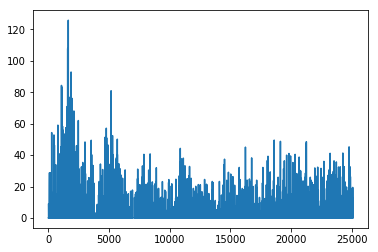

In [11]:
plt.plot(features[0].reshape(-1,))

In [13]:
features.shape, labels.shape

((3943, 25088), (3943,))

# Doing the Data Science Stuff
Create a shuffled array and separate out sets for training and testing.

In [12]:
shuffled = np.arange(0, imageCount)
np.random.shuffle(shuffled)
trainCount = int(.85*imageCount)
training = shuffled[0:trainCount]
testing = shuffled[trainCount:]
xTrain = features[training]
yTrain = labels[training]
xTest = features[testing]
yTest = labels[testing]

In [15]:
leftModel.output.shape[1]

Dimension(25088)

# The Right Half of our Model
Create my "right model." Input is the same size as the "flatten" layer of VGG16. A batch normalization layer helps the data fit to the model better. Two dense layers with 50% dropout after each (found this trick on the inernet and it seems to work). The output layer is a single node sigmoid.

In [13]:
x = Input(shape=(25088,))
y = BatchNormalization(gamma_initializer=initializers.Constant(value=1/40))(x)
y = Dense(4096, activation='relu')(y)
y = Dropout(0.5)(y)
y = Dense(4096, activation='relu')(y)
y = Dropout(0.5)(y)
y = Dense(1, activation='sigmoid')(y)
rightModel = Model(inputs=x, outputs=y)

In [10]:
rightModel.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 25088)             0         
_________________________________________________________________
batch_normalization (BatchNo (None, 25088)             100352    
_________________________________________________________________
dense (Dense)                (None, 4096)              102764544 
_________________________________________________________________
dropout (Dropout)            (None, 4096)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 4096)              16781312  
_________________________________________________________________
dropout_1 (Dropout)          (None, 4096)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 4097      
Total para

# Training the Right Half of our Model
Compile my right model and create callbacks before fitting the model.

In [14]:
rightModel.compile(loss='binary_crossentropy', optimizer='adamax')

In [15]:
callbacks = [EarlyStopping('val_loss', patience=2), ModelCheckpoint('rightModelWeights-gpu.h5', save_best_only=True)]

In [16]:
with tf.device('/cpu:0'):
    history = rightModel.fit(xTrain, yTrain, batch_size=32, epochs=20, shuffle=True, verbose=1, validation_data=(xTest, yTest), callbacks=callbacks)

Train on 3351 samples, validate on 592 samples
Epoch 1/20
3351/3351 [==============================] - 90s 27ms/step - loss: 0.1227 - val_loss: 0.0114
Epoch 2/20
3351/3351 [==============================] - 86s 26ms/step - loss: 0.0072 - val_loss: 7.0428e-04
Epoch 3/20
3351/3351 [==============================] - 86s 26ms/step - loss: 0.0043 - val_loss: 0.0019
Epoch 4/20
3351/3351 [==============================] - 87s 26ms/step - loss: 0.0047 - val_loss: 0.0044


Pretty awesome, huh?

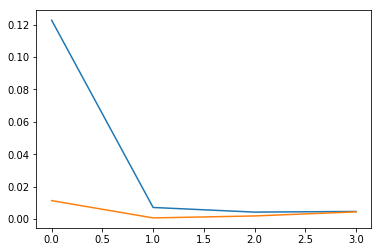

In [17]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

Load right model weights

In [18]:
rightModel.load_weights('rightModelWeights-gpu.h5')

# Setting Up the Combined Model
This is where the "bolting together" of the left and right models takes place. Instantiate an input tensor and use it as the input for the left model. Then we use the left model as the input for the right model. Finally, we create our classifier model with the input being our input tensor, and the output being the right model.

In [19]:
input = Input(shape=(224, 224, 3))
x = leftModel(input)
predict = rightModel(x)
classifier = Model(inputs=input, outputs=predict)
classifier.save_weights('classifierWeights-gpu.h5')

In [20]:
predict = rightModel.predict(xTest)

In [21]:
predict

array([[9.99997854e-01],
       [1.75021982e-04],
       [2.15531390e-12],
       [1.44083412e-09],
       [1.00000000e+00],
       [9.99999881e-01],
       [1.35968265e-04],
       [9.93172467e-01],
       [3.26229812e-04],
       [2.23493158e-15],
       [9.99998450e-01],
       [8.83340423e-09],
       [9.99886751e-01],
       [9.97749269e-01],
       [2.23465788e-04],
       [4.13450092e-04],
       [9.99954343e-01],
       [3.41536725e-06],
       [1.00000000e+00],
       [5.28293313e-04],
       [9.99998808e-01],
       [1.00000000e+00],
       [4.88457619e-04],
       [9.99976754e-01],
       [3.17595720e-07],
       [9.99789298e-01],
       [9.99999642e-01],
       [9.99972343e-01],
       [1.85884084e-04],
       [1.74298272e-14],
       [9.94881122e-11],
       [9.41577076e-04],
       [2.79345928e-04],
       [9.99952316e-01],
       [5.25989817e-05],
       [9.99966383e-01],
       [3.19753657e-04],
       [9.99956250e-01],
       [9.99925733e-01],
       [8.23220529e-04],


(array([299.,   0.,   0.,   0.,   0.,   0.,   0.,   1.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   1.,   0.,   1., 290.]),
 array([5.71644932e-21, 2.00000000e-02, 4.00000000e-02, 6.00000000e-02,
        8.00000000e-02, 1.00000000e-01, 1.20000000e-01, 1.40000000e-01,
        1.60000000e-01, 1.80000000e-01, 2.00000000e-01, 2.20000000e-01,
        2.40000000e-01, 2.60000000e-01, 2.80000000e-01, 3.00000000e-01,
        3.20000000e-01, 3.40000000e-01, 3.60000000e-01, 3.80000000e-01,
        4.00000000e-01, 4.20000000e-01, 4.40000000e-01, 4.60000000e-01,
        4.80000000e-01, 5.00000000e-01, 5.20000000e-01, 5.40000000e-01,
        5.60000000e-01, 5.80000000e-01, 6.00000000e-01, 6.20000000e-01,
        6.40000000e-01, 6.60000000e-01, 6.80000000e-01, 7.00000000e-01,
        7.

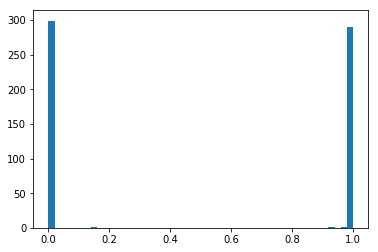

In [22]:
plt.hist(predict, 50)

In [23]:
p = (np.round(predict)).astype(int).reshape((-1,))
y = (yTest).astype(int)

In [24]:
correct = (p==y).astype(int)

In [25]:
print('percent correct: {:.4f}'.format( np.sum(correct) / len(correct) * 100 ))

percent correct: 100.0000


Resulting model is 100% accurate on the test data.

In [28]:
classifier.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
model (Model)                (None, 25088)             14714688  
_________________________________________________________________
model_1 (Model)              (None, 1)                 119650305 
Total params: 134,364,993
Trainable params: 134,314,817
Non-trainable params: 50,176
_________________________________________________________________
